In [39]:
import matplotlib.pyplot as plt
import pennylane as qml

from pennylane import numpy as np
import torch.optim as optim
import torch
import torch.nn as nn

from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

import pandas as pd
import sys
sys.path.append("../")
from qmg.utils import MoleculeQuantumStateGenerator

num_heavy_atom = 2
data_path = f"../dataset/chemical_space/effective_{num_heavy_atom}.csv"
data_generator = MoleculeQuantumStateGenerator(heavy_atom_size=num_heavy_atom, ncpus=16)
data = pd.read_csv(data_path)
data.head()



,decimal_index,smiles
0,4,C
1,8,O
2,12,N
3,16,C
4,21,CC


In [42]:
# Quantum variables
# n_a_qubits = 1  # Number of ancillary qubits / N_A
n_qubits = data_generator.n_qubits # + n_a_qubits  # Total number of qubits / N
q_depth = 6  # Depth of the parameterised quantum circuit / D
n_generators = 1  # Number of subgenerators for the patch method / N_G
sample_num = 2000 # Number of sampled molecules for validating the training
# data_reuploading = False

dev = qml.device("lightning.qubit", wires=n_qubits) # Quantum simulator
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Enable CUDA device if available
device = torch.device("cpu")
print(device)

valid_state_mask = data_generator.generate_valid_mask(data)
valid_state_mask = torch.Tensor(valid_state_mask).to(device)

cpu


In [43]:
@qml.qnode(dev, diff_method="parameter-shift")
def quantum_circuit(noise, weights, data_reuploading):
    weights = weights.reshape(q_depth, n_qubits * 3)
    for i in range(q_depth):
        if data_reuploading:
            for j in range(n_qubits):
                qml.RY(noise[j], wires=j)
        else:
            if i == 0:
                for j in range(n_qubits):
                    qml.RY(noise[j], wires=j)
        # Parameterised layer
        for y in range(n_qubits):
            qml.RZ(weights[i][3*y], wires=y)
            qml.RX(weights[i][3*y+1], wires=y)
            qml.RY(weights[i][3*y+2], wires=y)
        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CNOT(wires=[y, y + 1])
        else:
            qml.CNOT(wires=[y+1, 0])
    return qml.probs(wires=list(range(n_qubits)))

def binary_tensor_to_string(tensor):
    flat_tensor = tensor.view(-1).tolist()
    binary_string = ''.join(map(str, flat_tensor))
    return binary_string

def calc_validity_and_uniqueness(smiles_list):
    valid_smiles_list = [i for i in smiles_list if i is not None]
    return len(valid_smiles_list) / len(smiles_list), len(set(valid_smiles_list)) / len(smiles_list)

# def partial_measure(noise, weights):
#     # Non-linear Transform
#     probs = quantum_circuit(noise, weights)
#     probsgiven0 = probs[: (2 ** (n_qubits - n_a_qubits))]
#     probsgiven0 /= torch.sum(probsgiven0)

#     # # Post-Processing
#     # probsgiven = probsgiven0 / torch.max(probsgiven0)
#     return probsgiven0

class PatchQuantumGenerator(nn.Module):
    """Quantum generator class for the patch method"""
    def __init__(self, n_generators, valid_state_mask, q_delta=1, temperature=5, data_reuploading=False):
        """
        Args:
            n_generators (int): Number of sub-generators to be used in the patch method.
            q_delta (float, optional): Spread of the random distribution for parameter initialisation.
            temperature (float, optional): parameter adjusting the output probability distribution.
            data_reuploading (bool): whether to use the data reuploading technique.
        """
        super().__init__()
        self.q_params = nn.ParameterList(
            [
                nn.Parameter(q_delta * torch.rand(q_depth * n_qubits * 3), requires_grad=True)
                for _ in range(n_generators)
            ]
        )
        self.n_generators = n_generators
        self.valid_state_mask = valid_state_mask
        self.noise_to_probability_linear_layer = nn.Linear(n_qubits, 2**n_qubits)
        self.softmax_layer = nn.Softmax(dim=1)
        self.temperature = temperature
        self.data_reuploading = data_reuploading
        for param in self.noise_to_probability_linear_layer.parameters():
            param.requires_grad = False

    def forward(self, x):
        # Size of each sub-generator output
        patch_size = 2 ** n_qubits # 2 ** (n_qubits - n_a_qubits)
        # Create a Tensor to 'catch' a batch of images from the for loop. x.size(0) is the batch size.
        outputs = torch.Tensor(x.size(0), 0).to(device)
        # Iterate over all sub-generators
        for params in self.q_params:
            # Create a Tensor to 'catch' a batch of the patches from a single sub-generator
            patches = torch.Tensor(0, patch_size).to(device)
            for elem in x:
                q_out = quantum_circuit(elem, params, self.data_reuploading).float().unsqueeze(0) # partial_measure
                patches = torch.cat((patches, q_out))
            # Each batch of patches is concatenated with each other to create a batch of images
            outputs = torch.cat((outputs, patches), 1)

        # converted input noise
        converted_x = self.noise_to_probability_linear_layer(x) * self.temperature# - 10 * (1 - self.valid_state_mask) 
        # converted_x = self.softmax_layer(converted_x)
        return outputs, converted_x
    
    def random_sample(self, sample_num, fixed_noise=False):
        weights = torch.tensor([])
        state_dict = self.state_dict()
        for name, param in state_dict.items():
            if name in ["noise_to_probability_linear_layer.weight", "noise_to_probability_linear_layer.bias"]:
                continue
            weights = torch.cat([weights, param.data])
        if fixed_noise:
            dev_sample = qml.device("default.qubit", wires=n_qubits, shots=sample_num)
        else:
            dev_sample = qml.device("default.qubit", wires=n_qubits, shots=1)
        @qml.qnode(dev_sample)
        def quantum_circuit_sample(noise, weights, data_reuploading):
            weights = weights.reshape(q_depth, n_qubits * 3)
            for i in range(q_depth):
                if data_reuploading:
                    for j in range(n_qubits):
                        qml.RY(noise[j], wires=j)
                else:
                    if i == 0:
                        for j in range(n_qubits):
                            qml.RY(noise[j], wires=j)
                # Parameterised layer
                for y in range(n_qubits):
                    qml.RZ(weights[i][3*y], wires=y)
                    qml.RX(weights[i][3*y+1], wires=y)
                    qml.RY(weights[i][3*y+2], wires=y)
                # Control Z gates
                for y in range(n_qubits - 1):
                    qml.CNOT(wires=[y, y + 1])
                else:
                    qml.CNOT(wires=[y+1, 0])
            return qml.sample()
        
        
        if fixed_noise:
            noise = torch.rand(n_qubits, device=device) * np.pi / 2
            sampled_quantum_states = quantum_circuit_sample(noise, weights, self.data_reuploading) # 2-dimensional torch.tensor
        else:
            sampled_quantum_states = []
            for i in range(sample_num):
                noise = torch.rand(n_qubits, device=device) * np.pi / 2
                sampled_quantum_states.append(quantum_circuit_sample(noise, weights, self.data_reuploading))

        sampled_quantum_states = [binary_tensor_to_string(qs) for qs in sampled_quantum_states]
        smiles_list = []
        for q in sampled_quantum_states:
            smiles_list.append(data_generator.QuantumStateToSmiles(q))
        return smiles_list
    
drawer = qml.draw(quantum_circuit, show_all_wires=True, wire_order=list(range(n_qubits)), expansion_strategy="device")
noise = torch.rand(n_qubits, device=device) * np.pi / 2
weights = torch.rand(q_depth, n_qubits * 3)
print(weights.shape)
print(drawer(noise, weights, False))

torch.Size([6, 18])
0: ──RY(1.39)──RZ(0.06)──RX(0.99)──RY(0.42)─╭●─────────────╭X──RZ(0.39)──RX(0.93)──RY(0.54)─╭●──────
1: ──RY(0.03)──RZ(0.57)──RX(0.81)──RY(0.51)─╰X─╭●──────────│───RZ(0.30)──RX(0.91)──RY(0.05)─╰X─╭●───
2: ──RY(1.41)──RZ(0.21)──RX(0.23)──RY(0.35)────╰X─╭●───────│───RZ(0.27)──RX(0.91)──RY(0.65)────╰X─╭●
3: ──RY(0.02)──RZ(0.01)──RX(0.68)──RY(0.72)───────╰X─╭●────│───RZ(0.06)──RX(0.99)──RY(0.02)───────╰X
4: ──RY(0.78)──RZ(0.57)──RX(0.71)──RY(0.19)──────────╰X─╭●─│───RZ(0.42)──RX(0.95)──RY(0.37)─────────
5: ──RY(0.40)──RZ(0.82)──RX(0.21)──RY(0.94)─────────────╰X─╰●──RZ(0.38)──RX(0.78)──RY(0.30)─────────

────────╭X──RZ(0.65)──RX(0.91)──RY(0.71)─╭●─────────────╭X──RZ(0.86)──RX(0.47)──RY(0.03)─╭●─────────
────────│───RZ(0.75)──RX(0.65)──RY(0.02)─╰X─╭●──────────│───RZ(0.83)──RX(0.32)──RY(0.35)─╰X─╭●──────
────────│───RZ(0.80)──RX(0.82)──RY(0.25)────╰X─╭●───────│───RZ(0.30)──RX(0.56)──RY(0.54)────╰X─╭●───
──╭●────│───RZ(0.76)──RX(0.57)──RY(0.98)───────╰X─╭●────│───RZ(0.87)──

In [44]:
noise = torch.rand(8, n_qubits, device=device) * np.pi / 2
print(noise.shape)
generator = PatchQuantumGenerator(n_generators, valid_state_mask, data_reuploading=False).to(device)
print(generator)

output, converted_x = generator(noise)
print(output.shape)
print(converted_x.shape)
print(converted_x[1])
print(torch.sum(output[0]))

torch.Size([8, 6])
PatchQuantumGenerator(
  (q_params): ParameterList(  (0): Parameter containing: [torch.float32 of size 108])
  (noise_to_probability_linear_layer): Linear(in_features=6, out_features=64, bias=True)
  (softmax_layer): Softmax(dim=1)
)
torch.Size([8, 64])
torch.Size([8, 64])
tensor([ 5.5196, -3.8536, -2.4605, -0.7718, -3.0444, -3.7778,  1.5257,  1.6894,
         2.4601,  4.6384,  2.1685, -1.6691, -3.2748, -0.9333,  2.7755,  2.3099,
        -2.0354, -2.7791, -0.7890, -1.4811, -0.8917, -6.9078,  2.1025, -0.5557,
        -2.7805, -1.3127, -0.8759,  0.9312, -2.6462, -2.2877, -0.6191,  4.7163,
        -4.1985, -0.1422,  2.4960,  0.0259, -2.6579, -2.0169,  2.7834,  2.6082,
        -1.0776, -3.6454, -5.5505, -1.3573,  2.6991, -0.5373,  1.6365, -3.8647,
        -1.5355, -0.4470, -2.5301,  0.7358, -3.5461,  0.2384,  0.2967,  3.3985,
        -2.1383, -1.6908, -1.8006, -6.4132, -0.2336,  2.7593,  9.0583, -0.4380])
tensor(1., grad_fn=<SumBackward0>)


In [45]:
class valid_state_loss(nn.Module):
    def __init__(self, valid_state_mask: torch.tensor, reduction="mean"):
        """
        Parameters
        ----------
        valid_state_mask :  torch.tensor
            binart tensor, 1 indicates valid quantum state, and 0 indicates invalid.
        """
        super().__init__()
        self.valid_state_mask = valid_state_mask
        self.reduction = reduction

    def forward(self, predictions):
        loss = (predictions * self.valid_state_mask).sum(dim=1)
        if self.reduction == "mean":
            return torch.mean(-torch.log(loss))
        elif self.reduction == "sum":
            return torch.sum(-torch.log(loss))
        else:
            return -torch.log(loss)

class jenson_shannon_divergence(nn.Module):
    def __init__(self, valid_state_mask, reduction="batchmean"):
        """
        Parameters
        ----------
        valid_state_mask :  torch.tensor
            binart tensor, 1 indicates valid quantum state, and 0 indicates invalid.
        """
        super().__init__()
        self.valid_state_mask = valid_state_mask
        self.kl_div = nn.KLDivLoss(reduction=reduction, log_target=False)
        self.softmax_layer = nn.Softmax(dim=1)

    def forward(self, outputs, coverted_noise):
        outputs = outputs[:, self.valid_state_mask == 1.]
        coverted_noise = coverted_noise[:, self.valid_state_mask == 1.]
        converted_noise_probability = self.softmax_layer(coverted_noise)
        total_m = 0.5 * (outputs + converted_noise_probability)
        loss = 0.0
        loss += self.kl_div(outputs.log(), total_m) 
        loss += self.kl_div(converted_noise_probability.log(), total_m) 
        return (0.5 * loss)
    
class diversity_loss(nn.Module):
    def __init__(self, valid_state_mask, reduction="batchmean"):
        super().__init__()
        self.valid_state_mask = valid_state_mask
        self.kl_div = nn.KLDivLoss(reduction=reduction, log_target=False)

    def jensen_shannon_divergence(self, ps, qs):
        m = 0.5 * (ps + qs)
        return 0.5 * (self.kl_div(ps.log(), m) + self.kl_div(qs.log(), m))
    
    def forward(self, distributions):
        distributions = distributions[:, self.valid_state_mask == 1.]
        reversed_distributions = torch.flip(distributions, dims=[0])
        return - self.jensen_shannon_divergence(distributions, reversed_distributions)
    
class average_difference_probability_loss(nn.Module):
    def __init__(self, valid_state_mask):
        super().__init__()
        self.valid_state_mask = valid_state_mask
    
    def forward(self, distributions):
        half_length = len(distributions)//2
        distributions_first = distributions[:half_length][:, self.valid_state_mask == 1.]
        distributions_second = distributions[half_length:][:, self.valid_state_mask == 1.]
        # print(distributions[0])
        # print(reversed_distributions[0])
        return - torch.mean(torch.sum(torch.abs(distributions_first - distributions_second), dim=1))

In [46]:
a = output * valid_state_mask
loss = a.sum(dim=1)
print(loss)
torch.mean(-torch.log(loss))

criterion = valid_state_loss(valid_state_mask=valid_state_mask)
loss = criterion(output)
print(loss)
criterion_js = jenson_shannon_divergence(valid_state_mask=valid_state_mask, reduction="batchmean")
loss = criterion_js(output, converted_x)
print(loss)

criterion_diversity = diversity_loss(valid_state_mask=valid_state_mask, reduction="batchmean")
loss = criterion_diversity(output)
print(loss)
# print(loss.shape)
criterion_diversity_2 = average_difference_probability_loss(valid_state_mask)
loss = criterion_diversity_2(output)
print(loss)


tensor([0.4120, 0.4396, 0.3538, 0.3244, 0.3910, 0.3822, 0.4450, 0.3632],
       grad_fn=<SumBackward1>)
tensor(0.9496, grad_fn=<MeanBackward0>)
tensor(1.2729, grad_fn=<MulBackward0>)
tensor(-0.0511, grad_fn=<NegBackward0>)
tensor(-0.2724, grad_fn=<NegBackward0>)


In [47]:
from tqdm import tqdm
import os

save_dir = "models_5_sverage_difference"

os.makedirs(f"{save_dir}/heavy_atoms_{num_heavy_atom}", exist_ok=True)
criterion_js = jenson_shannon_divergence(valid_state_mask=valid_state_mask, reduction="batchmean")
criterion_valid = valid_state_loss(valid_state_mask)
# criterion_diversity = diversity_loss(valid_state_mask=valid_state_mask, reduction="batchmean")
criterion_diversity_2 = average_difference_probability_loss(valid_state_mask)
best_loss = 1e10

batch_size = 32
opt = optim.Adam(generator.parameters(), lr=0.1)
loss_js_history = []
loss_valid_state_history = []
loss_valid_history = []
valid_per_steps = 10

steps = 100
for i in range(steps):
    # Noise follwing a uniform distribution in range [0,pi/2)
    noise = torch.rand(batch_size, n_qubits, device=device) * np.pi / 2
    outputs, converted_noise = generator(noise)
    # loss_js = criterion_js(outputs, converted_noise)
    # loss_js_history.append(loss_js.detach().cpu())
    loss_diversity = criterion_diversity_2(outputs)

    loss_valid_state = criterion_valid(outputs)
    loss_valid_state_history.append(loss_valid_state.detach().cpu())
    loss = loss_valid_state + loss_diversity
        
    opt.zero_grad()
    loss.backward()
    opt.step()
    if float(loss.detach().cpu()) < best_loss:
        best_loss = float(loss.detach().cpu())
        torch.save(generator.state_dict(), f'{save_dir}/heavy_atoms_{num_heavy_atom}/best_generator.pt')

    print(f"Step {i+1}", loss_diversity, loss_valid_state, loss)
    if (i+1) % valid_per_steps == 0:
        sample_smiles_list = generator.random_sample(sample_num=sample_num)
        validity, uniqueness = calc_validity_and_uniqueness(sample_smiles_list)
        print(f"Step {i+1}, sampling {sample_num} molecules, validity: {validity*100}%, uniqueness: {uniqueness*100}%.")
        torch.save(generator.state_dict(), f'{save_dir}/heavy_atoms_{num_heavy_atom}/generator_{i+1}_steps.pt')

Step 1 tensor(-0.2767, grad_fn=<NegBackward0>) tensor(0.8117, grad_fn=<MeanBackward0>) tensor(0.5350, grad_fn=<AddBackward0>)
Step 2 tensor(-0.3956, grad_fn=<NegBackward0>) tensor(0.5069, grad_fn=<MeanBackward0>) tensor(0.1113, grad_fn=<AddBackward0>)
Step 3 tensor(-0.3553, grad_fn=<NegBackward0>) tensor(0.3873, grad_fn=<MeanBackward0>) tensor(0.0320, grad_fn=<AddBackward0>)
Step 4 tensor(-0.4324, grad_fn=<NegBackward0>) tensor(0.3895, grad_fn=<MeanBackward0>) tensor(-0.0429, grad_fn=<AddBackward0>)
Step 5 tensor(-0.4404, grad_fn=<NegBackward0>) tensor(0.3246, grad_fn=<MeanBackward0>) tensor(-0.1158, grad_fn=<AddBackward0>)
Step 6 tensor(-0.4308, grad_fn=<NegBackward0>) tensor(0.3123, grad_fn=<MeanBackward0>) tensor(-0.1185, grad_fn=<AddBackward0>)
Step 7 tensor(-0.4374, grad_fn=<NegBackward0>) tensor(0.3239, grad_fn=<MeanBackward0>) tensor(-0.1135, grad_fn=<AddBackward0>)
Step 8 tensor(-0.4865, grad_fn=<NegBackward0>) tensor(0.2959, grad_fn=<MeanBackward0>) tensor(-0.1906, grad_fn=<Ad

In [70]:
from collections import Counter
sample_num = 2000

generator = PatchQuantumGenerator(n_generators, valid_state_mask)
# 讀取模型參數
generator.load_state_dict(torch.load('models_3_data_reuploading/heavy_atoms_3/generator_100_steps.pt'))
generator.eval()  # 設定模型為評估模式（如需要）

sample_smiles_list = generator.random_sample(sample_num=sample_num, fixed_noise=True)
print(Counter(sample_smiles_list))
validity, uniqueness = calc_validity_and_uniqueness(sample_smiles_list)
# print(loss)
print(f"sampling {sample_num} molecules, validity: {validity*100}%, uniqueness: {uniqueness*100}%.")


Counter({None: 409, 'CN=N': 243, 'C1NN1': 211, 'C=NN': 163, 'CNC': 113, 'C=NC': 108, 'C1=CN1': 83, 'C1CC1': 80, 'C=CN': 70, 'CNN': 55, 'C1CN1': 52, 'N=NN': 33, 'NNN': 31, 'C.CN': 30, 'C1=NN1': 27, 'C1=NN=1': 19, 'C1#CC1': 18, '[nH]1[nH]o1': 17, 'C1CO1': 16, 'C1=NC1': 14, 'CN=O': 14, 'C.N=N': 13, 'CCC': 11, 'C#CC': 10, 'C1=CN=1': 10, 'CN.N': 10, 'C=CC': 10, 'C1NO1': 9, 'CCN': 9, 'N1=NN1': 9, 'NNO': 8, 'CC=N': 8, '[nH]1[nH][nH]1': 6, 'NC=O': 6, 'C=NO': 5, 'C1=CC1': 5, 'NCN': 5, 'N=NO': 5, 'C.NN': 4, 'N=CN': 4, 'C.N.N': 4, 'NCO': 4, 'C1N=N1': 3, 'COC': 3, 'C#CN': 3, 'C=[N+]=[N-]': 3, 'C.C=N': 3, 'C=N.N': 2, 'CCO': 2, 'C1#CN1': 2, 'NN=O': 2, 'NON': 2, 'C1=CO1': 1, 'N=CO': 1, 'C1=NO1': 1, '[N-]=[N+]=O': 1, 'N=C=N': 1, 'CON': 1, 'CC#N': 1, 'C=CO': 1, 'C.C=C': 1, 'C1=CC=1': 1, 'NN': 1, 'C=C=N': 1, 'C=N': 1, 'CNO': 1})
sampling 2000 molecules, validity: 79.55%, uniqueness: 3.25%.


In [40]:
z = 0
for x in set(sample_smiles_list):
    print(x)
    if x and ("." not in x):
        z += 1
print(z)
print(len(sample_smiles_list))
print(len(set(sample_smiles_list)))

CCC
C1CO1
[nH]1[nH]o1
C=CN
C1=NN=1
NC=O
C=N.N
C=C=N
C=NN
C1CC1
N.NN
NON
C1NO1
C.N.N
OCO
CC.N
C1=CC=1
N=NO
CN=O
NNO
C#CO
[nH]1oo1
C.C=N
C1=NC1
C1=CN1
[nH]1[nH][nH]1
NN=O
C1=CC1
C.CC
C1CN1
CNN
CC#N
N=CN
C.C=C
C#CN
CN.N
None
N1=NN1
C1=CN=1
N=NN
C=C=C
NNN
C=NO
C1N=N1
N=CO
C=CO
CC=O
NCN
NCO
CCO
CNC
CCN
C.CN
C=CC
CC=N
C.N=N
CN=N
C1=NN1
C1NN1
C#CC
CNO
N1=NO1
N#CN
C1#CN1
C=C.N
C=NC
C1#CC1
55
2000
67


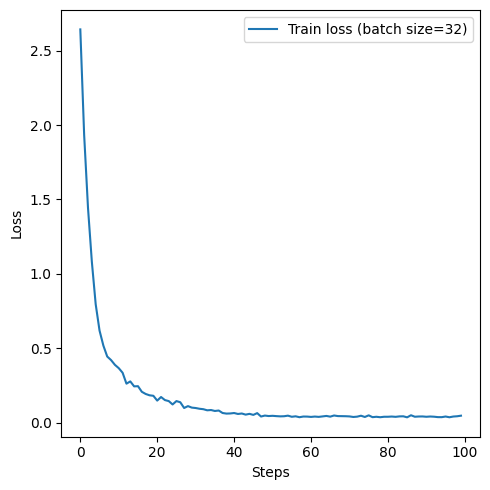

In [20]:
plt.figure(figsize=(5, 5))

plt.plot(loss_history, label=f'Train loss (batch size={batch_size})')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## TODO: write function for random smaple molecule SMILES.

In [12]:

# def random_sample(generator, num_molecules, data_generator):
generator.q_params
    

ParameterList(  (0): Parameter containing: [torch.float32 of size 108])

In [15]:
# def random_sample(generator, num_molecules, data_generator):
weights = torch.tensor([])
state_dict = generator.state_dict()
for name, param in state_dict.items():
    print(name)
    weights = torch.cat([weights, param.data])

q_params.0 tensor([-6.1403e-01,  6.8589e-01, -8.2242e-01,  2.8891e-03,  7.2007e-01,
         9.6816e-01, -7.8608e-01, -3.3917e-04,  1.2507e+00, -6.3094e-01,
        -8.1984e-01,  4.7613e-04,  2.3608e+00,  5.9280e-02, -7.3479e-01,
        -1.2768e-01,  8.9564e-01,  1.4311e+00, -7.8910e-01, -4.3922e-02,
         2.1609e+00,  5.1940e-01, -9.8968e-01,  7.7408e-01,  1.5925e+00,
         1.1653e+00, -3.6929e-03,  2.4755e-03,  1.5733e+00,  6.7595e-02,
         7.2887e-04,  7.8670e-03,  1.5778e+00,  2.0184e-01, -1.4096e-02,
        -1.0092e-02,  2.4204e-02,  6.0875e-03, -5.9460e-03, -2.0760e-04,
         3.3274e-02,  1.9868e-01,  1.5212e-03,  6.1897e-03,  5.4395e-02,
        -6.9438e-02,  7.6293e-02, -2.0426e-01,  8.5052e-01,  1.3071e-02,
        -1.9599e-03, -4.9723e-03,  5.2085e-02,  1.2249e-02, -4.0249e-04,
        -7.0410e-03, -1.9441e-01,  6.0722e-03,  7.5010e-03,  2.0489e-03,
        -7.2583e-03, -6.4861e-02, -1.0081e-01,  1.2406e-01,  1.5557e+00,
        -1.3705e-01,  2.1734e-02,  4.681

In [42]:
weights = torch.tensor([])
state_dict = generator.state_dict()
for name, param in state_dict.items():
    print(name)
    weights = torch.cat([weights, param.data])

dev_sample = qml.device("default.qubit", wires=n_qubits, shots=20)
@qml.qnode(dev_sample)
def quantum_circuit_sample(noise, weights):
    weights = weights.reshape(q_depth, n_qubits * 2)
    # Initialise latent vectors
    for i in range(n_qubits):
        qml.RY(noise[i], wires=i)
    # Repeated layer
    for i in range(q_depth):
        # Parameterised layer
        for y in range(n_qubits):
            qml.RY(weights[i][2*y], wires=y)
            qml.RX(weights[i][2*y+1], wires=y)
        # Control Z gates
        for y in range(n_qubits - 1):
            qml.CZ(wires=[y, y + 1])
    return qml.sample()

def binary_tensor_to_string(tensor):
    if not torch.all((tensor == 0) | (tensor == 1)):
        raise ValueError("The tensor must be binary (contain only 0 and 1).")
    flat_tensor = tensor.view(-1).tolist()
    binary_string = ''.join(map(str, flat_tensor))
    return binary_string

noise = torch.rand(n_qubits, device=device) * np.pi / 2
print(noise)
sampled_quantum_states = quantum_circuit_sample(noise, weights)

sampled_quantum_states = [binary_tensor_to_string(qs) for qs in sampled_quantum_states]
print(sampled_quantum_states)

for q in sampled_quantum_states:
    print(data_generator.QuantumStateToSmiles(q))

q_params.0
tensor([1.4980, 0.2461, 0.7691, 0.9030, 0.8347, 0.3899, 1.2255, 1.1860, 0.7066,
        0.4137, 0.4713, 1.0023])
['111111100100', '110111010101', '001111010101', '111111010101', '111111010101', '111111010101', '101111010101', '111111010101', '111111010101', '111111010101', '111111010101', '111111010101', '111111010101', '111111010101', '111111100101', '111111010101', '111111010001', '111110010101', '011111010101', '111111010101']
N=NN
C1NN1
None
[nH]1[nH][nH]1
[nH]1[nH][nH]1
[nH]1[nH][nH]1
[nH]1[nH]o1
[nH]1[nH][nH]1
[nH]1[nH][nH]1
[nH]1[nH][nH]1
[nH]1[nH][nH]1
[nH]1[nH][nH]1
[nH]1[nH][nH]1
[nH]1[nH][nH]1
N1=NN1
[nH]1[nH][nH]1
NNN
[nH]1[nH]o1
C1NN1
[nH]1[nH][nH]1


In [24]:
import numpy
# numpy.array(sampled_quantum_states)
numpy.where(numpy.array(sampled_quantum_states) == 0, 1, 0)

array([[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0],
       [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]])